# Демодуляция. 
# Часть 3. Double Sideband Transmitted Carrier 
# (AM-DSB-TC)

## 2. Некогерентная демодуляция при квадратурном приеме

Рассмотрим как изменится структура некогерентного демодулятора в случае квадратурного приема. Сигнал теперь комплексный с односторонним спектром. Отличае от случая действительнго сигнала заключается в том, что теперь АМ-сигнал имеет вид:

$$s_{\textrm{am}} ={A\left(t\right)\cdot e}^{j\cdot \omega_с t}.$$ 

Если при формировании сигнала выполнено условие $A_с \ge m_{\max }$, то информационное сообщение можно восстановить из огибающей сигнала. Чтобы найти огибающую комплексного сигнала, достаточно вычислить его модуль. Схема приемника очень простая и представлена ниже:

<img src="../../images/DSB_TC_Receiver_3_2.png" width=500/>

Ниже представлен скрипт, выполняющий некогерентный прием сигнала с амплитудной модуляцией. 

<IPython.core.display.Javascript object>


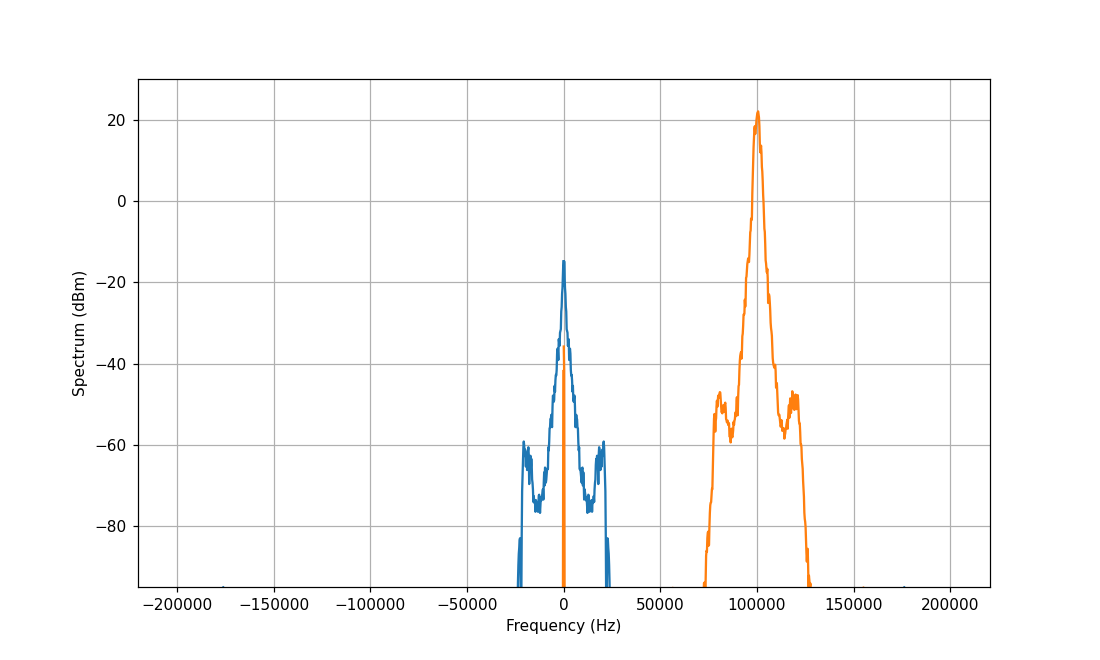

In [3]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 3              # коэффициент усиления аудиосигнала
mod_index = '02'           # индекс модуляции ('02' = 0.2, '06' = 0.6, '1' = 1)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open(f'../../wav/Audio_FM_ModIdx_{mod_index}.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-95, 30)
ax.grid(True)

# создаем три линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

# предыдущий отсчет в пачке    
last_sample = 0

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    fm_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    fm_signal = np.frombuffer(fm_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    fm_signal = np.reshape(fm_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    fm_signal = (fm_signal[:,0] + 1j*fm_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
    # вычисление производной с помощью первой разности
    fm_signal_delayed = np.concatenate(([last_sample], fm_signal[0:-1]))
    fm_signal_diff = fm_signal - fm_signal_delayed
    last_sample = fm_signal[-1]
    
    # вычисление модуля
    baseband_signal = np.abs(fm_signal_diff)
    
    # посторение спектрограмм
    signals = baseband_signal, fm_signal
    
    for i in range(2):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = baseband_signal - baseband_signal.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены временные диаграммы сигналов на входе (синий, действительная составляющая) и выходе (оранжевый) демодулятора. Можно увидеть, что сигнал на выходе фильтра совпадает с огибающей АМ-сигнала. 

На слух можно сделать вывод, что аудиосообщение восстанавливается без явных искажений.

In [3]:
%matplotlib notebook
%reset -f



import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from pylab import *
from rtlsdr import *

from scipy.signal import welch, resample_poly

# signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
# frames_number = 500        # число обрабатываемых пачек данных
# rate_ratio = 10            # коэффициент увеличения частоты дискретизации
# audio_amp = 3              # коэффициент усиления аудиосигнала
# mod_index = '02'           # индекс модуляции ('02' = 0.2, '06' = 0.6, '1' = 1)

# # открываем файл и получаем частоту дискретизации
# signal_file = wave.open(f'../../wav/Audio_FM_ModIdx_{mod_index}.wav')
# signal_fs = signal_file.getframerate()

# # частота дискретизации и размер кадра после передискретизации
# audio_fs = signal_fs / rate_ratio
# audio_frame_size = signal_frame_size / rate_ratio

# # построение осей графиков
# plt.rcParams['figure.figsize'] = [10, 6]
# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Spectrum (dBm)')
# ax.set_xlim(-signal_fs/2, signal_fs/2)
# ax.set_ylim(-95, 30)
# ax.grid(True)

# # создаем три линии для будущих графиков
# for _ in range(2):
#     ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

# # предыдущий отсчет в пачке    
# last_sample = 0

# message = []

# t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

# for frame in range(frames_number):

#     # формирование отсчетов аудиосигнала
#     fm_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
#     fm_signal = np.frombuffer(fm_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
#     fm_signal = np.reshape(fm_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
#     fm_signal = (fm_signal[:,0] + 1j*fm_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
#     # вычисление производной с помощью первой разности
#     fm_signal_delayed = np.concatenate(([last_sample], fm_signal[0:-1]))
#     fm_signal_diff = fm_signal - fm_signal_delayed
#     last_sample = fm_signal[-1]
    
#     # вычисление модуля
#     baseband_signal = np.abs(fm_signal_diff)
    
#     # посторение спектрограмм
#     signals = baseband_signal, fm_signal
    
#     for i in range(2):
#         f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
#         spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
#         ax.lines[i].set_xdata(f)
#         ax.lines[i].set_ydata(spectrum_dBm)
    
#     # отрисовка графиков
#     fig.canvas.draw() 
    
#     # удаление постоянной составляющей и уменьшение частоты дискретизации
#     baseband_signal = baseband_signal - baseband_signal.mean()
#     audio_data = resample_poly(baseband_signal, 1, rate_ratio)
#     message = np.concatenate((message, audio_data))
    
#     # обновляем отсчеты времени
#     t = t + signal_frame_size/signal_fs 

# sounddevice.play(message * audio_amp, audio_fs, blocking=True)

FileNotFoundError: [Errno 2] No such file or directory: b'liblibrtlsdr.a'

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR